### Data challenge for IBM
Please email your questions to mehdi.lamee@gmail.com
Thanks.

In [1]:
import time
import string
import pandas as pd
import numpy as np
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
ps = PorterStemmer()

pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',2000)
pd.set_option('display.max_colwidth',-1)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.float_format', lambda x: '%.4f' % x)

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set(color_codes=True)
%config InlineBackend.figure_format = 'retina'

stemmer = nltk.stem.porter.PorterStemmer()
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

from stop_words import get_stop_words
import math as math
import imp
import h2o
from h2o.estimators.kmeans import H2OKMeansEstimator

from wordcloud import WordCloud
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import FastText
# spacy for lemmatization
#import spacy
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings(action='once')

In [2]:
pap=pd.read_csv('Papers.csv')
print pap.shape
pap.head(1)

(403, 6)


Id  \
0  5677   

                                                                      Title  \
0  Double or Nothing: Multiplicative Incentive Mechanisms for Crowdsourcing   

  EventType  \
0  Poster     

                                                                            PdfName  \
0  5677-double-or-nothing-multiplicative-incentive-mechanisms-for-crowdsourcing.pdf   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Abstract  \
0  Crowdsourcing has gained immense popularity in machine learning applications for obtaining large amounts of labeled data. Crowdsourcing is cheap and fast, but suffers from the problem of low-quality data. To address this fundamental challenge in crowdsourcing, we propose a simple payment mechanism to incentivize workers to answer only the questions that they are sure of and skip the rest. We show that surprisingly, under a mild and natural no-free-lunch requirement, this mechanism is the one and only incentive-compatible payment mechanism possible. We also show that among all possible incentive-compatible  mechanisms (that may or may not satisfy no-free-lunch), our mechanism makes the smallest possible payment to spammers.  Interestingly, this unique mechanism takes a multiplicative form. The simplicity of the mechanism is an added benefit.  In preliminary experiments involving over several hundred workers, we observe a significant reduction in the error rates under our unique mechanism for the same or lower monetary expenditure.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [37]:
# Parsing text and keeping .!? for identifying sentenses.
def parse(s):
    temp = re.sub(r'[^A-Za-z.!?\s]', r' ', str(s)).strip().lower()
    return(temp)

# Parsing text and only keeping alphabetical charecters 
def parse2(s):
    temp = re.sub(r'[^A-Za-z\s]', r' ', str(s)).strip()
    return(temp)

# Identify and group high level adjectives, verbs, nouns, etc. 
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None # for easy if-statement 
    
# Lemmatization of words based on the their part of speech tag    
def lemma(x):
    wntag = get_wordnet_pos(x['pos'])
    if wntag is None:# not supply tag in case of None
        lemma = wordnet_lemmatizer.lemmatize(x['word']) 
    else:
        lemma = wordnet_lemmatizer.lemmatize(x['word'], pos=wntag)
    return lemma

# Text preprocessing function. It accepts the data file and has multiple options: \
#   1. remove stopping words, 2. Adding a list of manual stopwords, 3. Part of speech tagging, 4. Keeping only a set of tags: e.g. nouns and adjectives, 
#  5. Lemmatization. All of these options can be turned on and off
def prep(data,lemmatize=True,remove_stops=True,manuals=[],keeplist=[]):
    msh=pd.DataFrame()
    start_time = time.time()
    #print start_time
    # Iterating over text of each dataer
    num_docs=data.shape[0]
    for i in range(num_docs):
        print 'Processing document ', i+1, ' of ', num_docs
        # Parse the text and only keep alphabetical charecters. Then tokenize and run a part of speech tagger. 
        tmp=pd.DataFrame(nltk.pos_tag(nltk.word_tokenize(parse(data.iloc[i,-1])),lang='eng'))
        
        # Adding an if statement to check if the tmp dataframe actually has values to avoid errors due to problems in data. (One of the article's text is just garbage.)
        if tmp.shape[0]>0:
            if len(keeplist)>0:
                # Only keep words with specified part of speech tags
                tmp=tmp[tmp[1].isin(keeplist)]
            tmp['paper_id']=data.iloc[i,0]
            msh=msh.append(tmp)
    # Renaming column names to something that make sense    
    msh=msh.rename(columns={0:'word',1:'pos'})        
    if lemmatize==True:
        msh['word']=msh.apply(lemma, axis=1)
        
    print msh.columns
    if remove_stops==True:
        stopwords = pd.DataFrame({'stop_words':np.array(list(nltk.corpus.stopwords.words('english')))})
        if len(manuals)>0:
            manual_stops=pd.DataFrame({'stop_words':manuals})
            alphabet=pd.DataFrame({'stop_words':np.array(list(string.ascii_lowercase))})
            manual_stops=manual_stops.append(alphabet)
            manual_stops=manual_stops.append(alphabet+'.')
        else:         
            manual_stops=pd.DataFrame({'stop_words':np.array(list(string.ascii_lowercase))})
        stopwords=stopwords.append(manual_stops)
        #Getting rid of stopping words
        msh=msh[~msh['word'].isin(stopwords.values[:,0])]

    # Getting rid any potential NaN value
    msh=msh[~msh.word.isnull()]
    
    # Saving the processed data
    msh.to_csv('msh.csv',index=False)
    print("--- %s minutes ---" % (time.time()/60.0 - start_time/60.0))
    return msh


# Make bigrams of words
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Make trigrams of words
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Training a FastText embedding model with size=1000 for each word vector. I also set the window parameter to 5 and minimum counts of each word to be considered 3.
def train_fasttex(data,min_count=3,window=5,size=1000,name='model.txt'):
    start_time = time.time()
    msh_fastex = FastText(data, min_count=min_count, workers=8,window=window,size=size)
    print 'Saving the FastTex model in ',name
    msh_fastex.wv.save_word2vec_format(name, binary=False)
    print("--- %s minutes ---" % (time.time()/60.0 - start_time/60.0))
    return msh_fastex

# Evaluating the results of K-means clustering models by calculating metrics such as AIC and BIC 
def diagnostics_from_clusteringmodel(model):
    total_within_sumofsquares = model.tot_withinss()
    number_of_clusters = len(model.centers())
    number_of_dimensions = len(model.centers()[0])
    number_of_rows = sum(model.size())
    
    aic = total_within_sumofsquares + 2 * number_of_dimensions * number_of_clusters
    bic = total_within_sumofsquares + math.log(number_of_rows) * number_of_dimensions * number_of_clusters
    
    return {'Clusters':number_of_clusters,
            'Total Within SS':total_within_sumofsquares, 
            'AIC':aic, 
            'BIC':bic}

# Accepts a dataframe with a least two columns: 'word' list and its associated topic cluster: 'Cluster'
# Outputs a word cloud diagram of each topic with first 20 words in each cluster as well as a new dataframe with freqquency-weights of each word in each cluster. 
def cloud_plot(data, corpus, name):
    num=data.Cluster.nunique()
    sqt=int(np.round(math.sqrt(num)))
    print 'SQT ',sqt
    print 'Num ',num
    if (sqt**2>=num):
        row=sqt
        col=sqt
    else:
        row=sqt+1
        col=sqt
    print 'row ', row, ' col ', col
    plt.figure(1)
    ax,fig= plt.subplots(row,col,dpi=75,figsize=(col*10,row*8),tight_layout=True)
    plt.axis("off")
    i=1
    weights=pd.DataFrame({'word':[]})
    for group in data.Cluster.unique():
        plt.subplot(row,col,i)
        #make a temporary  dataframe with all words in cluster=group
        flat_corpus = pd.Series([item for sublist in corpus for item in sublist])
        tmp=flat_corpus[flat_corpus.isin(data[data.Cluster== group].word.values)].values
        # Calculates weights of each word in each cluster
        weights = pd.concat([weights,pd.DataFrame(1.0*pd.DataFrame({'word':tmp}).word.value_counts()/tmp.shape[0])])
        text=' '.join(tmp)
        wordcloud = WordCloud(max_words=10,max_font_size=40,collocations=False,repeat=False,prefer_horizontal=1,width=400, height=400, background_color="whitesmoke",color_func=lambda *args, **kwargs: "Teal").generate(text)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title('Cluster '+str(group),fontsize=30)
        plt.margins(x=0, y=0)
        i=i+1
    weights=weights.rename(columns={'word':'weight'},index=str)
    data=data.set_index('word').join(weights,how='left')
    plt.savefig(name,format='pdf',facecolor='white', edgecolor='none')
    plt.show()
    return data

# Generates a TSNE plot of the input document. witn n_components=n number of PCA components and the assigned perplexity.
def tsne_plot(docs,name,perplexity=3, n_components=2):
    "Creates and TSNE model and plots it"
    labels = docs.iloc[:,0]
    tokens = []

    for i in range(docs.shape[0]):
        tokens.append(docs.iloc[i,1:])
        #labels.append(word)
    
    tsne_model = TSNE(perplexity=perplexity, n_components=n_components, init='pca', n_iter=2500, random_state=230)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(20, 20)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.savefig(name,format='pdf')
    plt.show()

In [4]:
# Adding some manual stop words
manuals=['et', 'al','page']
# Only keeping Nouns, adjectives and verbs
keeplist=['NNS', 'VBP', 'VBN', 'NN', 'VBD', 'VBZ','VBG', 'JJ', 'VB', 'JJR', 'JJS', 'NNP','NNPS']
msh=prep(pap,lemmatize=True,remove_stops=True,manuals=manuals,keeplist=keeplist)
print msh.shape
msh.head()

Processing document  1  of  403
Processing document  2  of  403
Processing document  3  of  403
Processing document  4  of  403
Processing document  5  of  403
Processing document  6  of  403
Processing document  7  of  403
Processing document  8  of  403
Processing document  9  of  403
Processing document  10  of  403
Processing document  11  of  403
Processing document  12  of  403
Processing document  13  of  403
Processing document  14  of  403
Processing document  15  of  403
Processing document  16  of  403
Processing document  17  of  403
Processing document  18  of  403
Processing document  19  of  403
Processing document  20  of  403
Processing document  21  of  403
Processing document  22  of  403
Processing document  23  of  403
Processing document  24  of  403
Processing document  25  of  403
Processing document  26  of  403
Processing document  27  of  403
Processing document  28  of  403
Processing document  29  of  403
Processing document  30  of  403
Processing document

,word,pos,paper_id
2,nothing,NN,5677
3,multiplicative,JJ,5677
4,incentive,NN,5677
5,mechanism,NNS,5677
7,crowdsourcing,VBG,5677


In [5]:
# Making a list corpus of tokenized papers
papers=[]
for i in msh.paper_id.unique():
    papers=papers+[list(msh[msh.paper_id==i].word)]

In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(papers, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[papers], threshold=100)  

#trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# making Tri-bigrams
papers_trigrams = make_trigrams(make_bigrams(papers))

# Just making a replica array of papers_trigrams but with the paper_ids
j=0
paper_id=[]
for i in msh.paper_id.unique():
    paper_id=paper_id+[[i]*len(papers_trigrams[j])]
    j=j+1

/anaconda2/lib/python2.7/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


### Training a FastTex embedding on our Tri-gram version of corpus.
I choose size of 1000, window width of 5 and minimum word count of 3. These choices are not optimized.   
The result will be saved in a text file provided in "name" variable.

In [7]:
msh_fastex=train_fasttex(papers_trigrams,min_count=3,window=5,size=1000, name='nips_fasttex.txt')

/anaconda2/lib/python2.7/site-packages/gensim/models/fasttext.py:363: DeprecationWarning: Call to deprecated `bucket` (Attribute will be removed in 4.0.0, use trainables.bucket instead).
  self.wv.bucket = self.bucket
/anaconda2/lib/python2.7/site-packages/gensim/models/fasttext.py:497: DeprecationWarning: Call to deprecated `layer1_size` (Attribute will be removed in 4.0.0, use self.trainables.layer1_size instead).
  l1_size = self.layer1_size * np.dtype(np.float32).itemsize
/anaconda2/lib/python2.7/site-packages/gensim/models/fasttext.py:510: DeprecationWarning: Call to deprecated `min_n` (Attribute will be removed in 4.0.0, use wv.min_n instead).
  ngrams = _compute_ngrams(word, self.min_n, self.max_n)
/anaconda2/lib/python2.7/site-packages/gensim/models/fasttext.py:510: DeprecationWarning: Call to deprecated `max_n` (Attribute will be removed in 4.0.0, use wv.max_n instead).
  ngrams = _compute_ngrams(word, self.min_n, self.max_n)


Saving the FastTex model in  nips_fasttex.txt
--- 2.28222129866 minutes ---


### Preparing data
At this stage, I will use the fast implementation of a K-means clustering algorithm in H2O machine learning platform
to cluster all extracted words in our corpus based on their trained embedings. These clusters can be used for multiple purposes:
1. The top most frequent keywords in each cluster can be used as potential important keywords related to the context of papers and field. 
In other words, using this techique, we should be able to extract most relevant keywords of the corpus that represent the NIPS conference. We also will know the context of each cluster of keywords. 
One advatage of this methodology is that not only we will capture the dominant and most frequent sets of keywords, we also will identify small subsets of keywords related to a technical field that only a few papers have talked about. 
2. We later will use these word cluster as a proxy to probability of belonging each paper to each of these clusters.

In [9]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,4 days 3 hours 31 mins
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.8
H2O cluster version age:,5 months and 17 days !!!
H2O cluster name:,H2O_from_python_mlamee_squ6mj
H2O cluster total nodes:,1
H2O cluster free memory:,2.879 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [10]:
X = msh_fastex[msh_fastex.wv.vocab]
vocabs=np.array(list(msh_fastex.wv.vocab))
result=pd.DataFrame(X)
result['word']=vocabs
result=result.set_index('word')
newwd_h=h2o.H2OFrame(result.reset_index(),column_names=list(result.reset_index().columns.astype(str)))
result.head()

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


Parse progress: |█████████████████████████████████████████████████████████| 100%


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
word,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
bshouty,-0.0357,0.0199,0.0051,0.0561,-0.0671,-0.0916,-0.0297,0.0499,-0.0407,-0.0426,-0.0731,-0.0411,-0.0867,-0.0485,-0.0591,0.0106,0.0226,-0.0154,0.1062,0.1157,-0.0351,0.0961,0.1410,0.1196,-0.0115,0.0310,-0.0769,-0.0457,0.0296,0.0067,0.1926,0.0438,0.0020,0.0441,0.0814,-0.1339,0.0137,-0.0811,-0.1157,0.0086,0.0633,-0.1411,-0.0764,-0.0188,-0.1211,0.0107,-0.0269,0.0447,-0.0142,0.0284,0.0000,-0.0522,0.0055,0.0883,0.0672,0.0679,-0.0499,-0.0341,-0.0909,-0.0762,-0.0435,0.1217,0.0464,-0.0632,-0.0086,0.0710,0.1106,-0.0191,-0.0167,-0.1652,0.1408,0.0236,0.1589,0.0218,0.0798,0.1234,0.0553,0.0625,-0.0378,0.0497,0.0672,0.1148,0.0073,0.0978,0.0034,-0.0391,-0.0236,0.0706,0.1946,-0.0785,-0.0656,-0.0863,-0.0310,-0.0711,-0.0315,-0.0500,0.0335,0.0801,-0.0380,0.1690,...,-0.0827,-0.0814,0.0205,0.0291,-0.0090,-0.0497,-0.0151,-0.0010,-0.0138,0.0053,-0.0328,-0.0068,-0.0618,0.0075,0.0035,0.0381,0.0139,-0.0110,0.0701,-0.0007,0.0462,0.0064,-0.0394,-0.0220,-0.0116,-0.0122,0.0358,-0.0329,-0.0480,0.0139,-0.0332,0.0317,0.0401,-0.0013,0.0172,0.0297,0.0338,-0.0239,-0.0053,0.0246,-0.0499,-0.0082,-0.0448,0.0256,-0.0433,-0.0172,-0.0432,-0.0885,0.0244,-0.0160,-0.0221,0.0285,0.0277,-0.0443,-0.0270,0.0076,-0.0656,-0.1050,-0.0162,-0.0242,-0.0270,-0.0037,0.0284,-0.0341,-0.0214,0.0275,0.0394,0.0050,0.0591,-0.0383,-0.0378,0.0049,0.0161,-0.0124,-0.0341,-0.0020,-0.0423,-0.0506,-0.0834,0.0048,-0.0553,0.0168,0.0102,0.0489,0.0444,0.0287,0.0488,-0.0042,-0.0602,-0.0464,0.0215,0.0243,-0.0182,-0.0015,-0.0565,0.0169,-0.0285,-0.0601,0.0439,-0.0274
homomorphism,-0.0114,0.0372,-0.0027,0.1053,-0.0465,-0.1116,-0.0287,0.0624,0.0293,-0.0245,-0.0777,-0.0147,-0.0785,-0.0634,-0.0530,-0.0189,-0.0270,-0.0600,0.1201,0.0863,-0.0142,0.0407,0.0482,0.1362,0.0281,0.0128,-0.0372,-0.0870,0.0530,-0.0538,0.1843,0.0269,-0.0771,-0.0399,0.0378,-0.1370,0.0871,-0.1588,-0.0985,0.0187,0.0174,-0.0890,-0.0209,-0.0241,-0.1770,0.0357,-0.0387,0.0096,-0.0156,0.0608,-0.0689,-0.0363,0.0017,0.0451,0.0665,0.0618,-0.0247,-0.0137,-0.0523,-0.0766,-0.0098,0.1092,0.0656,-0.0679,0.0227,0.0347,0.1193,0.0213,-0.0224,-0.1624,0.1383,0.0415,0.0979,0.0347,0.1324,0.1219,0.0201,0.0648,-0.1038,0.0328,0.0749,0.0735,-0.0550,0.0721,0.0368,0.0260,-0.0462,0.0097,0.2429,-0.0687,-0.0612,-0.0823,-0.0580,-0.0567,-0.0323,-0.0370,0.0541,0.0261,-0.0321,0.1706,...,0.0109,0.0067,-0.0059,0.0095,-0.0043,0.0394,0.0243,-0.0139,-0.0097,-0.0119,-0.0278,-0.0087,-0.0080,-0.0037,0.0185,0.0291,0.0717,-0.0245,0.0335,-0.0104,0.0222,0.0483,-0.0083,-0.0469,-0.0154,-0.0417,-0.0361,-0.0406,-0.0439,0.0295,0.0294,-0.0234,-0.0104,-0.0304,-0.0281,-0.0129,-0.0181,-0.0500,-0.0412,0.0125,0.0160,0.0560,0.0445,-0.0066,-0.0513,0.0225,-0.0209,-0.0063,0.0023,-0.0187,-0.0203,0.0125,0.0406,-0.0014,-0.0572,-0.0283,0.0428,-0.0067,-0.0072,-0.0388,0.0246,-0.0436,-0.0063,-0.0005,-0.0037,0.0158,0.0228,0.0119,-0.0123,0.0038,-0.0422,-0.0203,-0.0315,-0.0319,0.0073,0.0092,0.0366,-0.0472,-0.0281,-0.0327,0.0166,0.0546,0.0295,0.0088,-0.0111,0.0319,-0.0120,0.0241,-0.0107,0.0001,-0.0187,-0.0385,-0.0061,-0.0112,-0.0194,0.0108,0.0314,0.0036,-0.0235,-0.0089
schlegel,0.0670,0.0200,-0.0022,0.0674,0.0429,0.1530,0.

### Kmeans clustering on words
The clustering of keywords happen here. I have desinged this code woith capability of optimizing for number of clusters based on the minimum value of the BIC parameter.
We can provide minimum and maximum numbers of k and the step interval. Then the algorithm perform a grid search over the parameter space and choose the k value that minimizes BIC.
However, for sake of simplicity, here I just randomly choose 20 clusters and work with that.
The results will be saved in a data frame called: "newpd"

In [11]:
minn=15
maxx=16
step=1
results = [H2OKMeansEstimator(k=clusters, init="PlusPlus", seed=2, standardize=True) for clusters in range(minn,maxx, step)]
for estimator in results:
    estimator.train(x=list(pd.DataFrame(result).columns), training_frame = newwd_h[1:])

diagnostics = pd.DataFrame( [diagnostics_from_clusteringmodel(model) for model in results])
diagnostics.set_index('Clusters', inplace=True)


best_cluster=diagnostics[diagnostics['BIC']==diagnostics['BIC'].min()].index[0]
print 'Number of clusters used, K: ', best_cluster
# print results
predicted = results[(best_cluster-minn)/step].predict(newwd_h)
newwd_h["Cluster"] = predicted["predict"].asnumeric()
newpd=newwd_h.as_data_frame(True)
newpd.head()

kmeans Model Build progress: |████████████████████████████████████████████| 100%
Number of clusters used, K:  15
kmeans prediction progress: |█████████████████████████████████████████████| 100%


,word,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,...,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,Cluster
0,bshouty,-0.0357,0.0199,0.0051,0.0561,-0.0671,-0.0916,-0.0297,0.0499,-0.0407,-0.0426,-0.0731,-0.0411,-0.0867,-0.0485,-0.0591,0.0106,0.0226,-0.0154,0.1062,0.1157,-0.0351,0.0961,0.1410,0.1196,-0.0115,0.0310,-0.0769,-0.0457,0.0296,0.0067,0.1926,0.0438,0.0020,0.0441,0.0814,-0.1339,0.0137,-0.0811,-0.1157,0.0086,0.0633,-0.1411,-0.0764,-0.0188,-0.1211,0.0107,-0.0269,0.0447,-0.0142,0.0284,0.0000,-0.0522,0.0055,0.0883,0.0672,0.0679,-0.0499,-0.0341,-0.0909,-0.0762,-0.0435,0.1217,0.0464,-0.0632,-0.0086,0.0710,0.1106,-0.0191,-0.0167,-0.1652,0.1408,0.0236,0.1589,0.0218,0.0798,0.1234,0.0553,0.0625,-0.0378,0.0497,0.0672,0.1148,0.0073,0.0978,0.0034,-0.0391,-0.0236,0.0706,0.1946,-0.0785,-0.0656,-0.0863,-0.0310,-0.0711,-0.0315,-0.0500,0.0335,0.0801,-0.0380,...,-0.0814,0.0205,0.0291,-0.0090,-0.0497,-0.0151,-0.0010,-0.0138,0.0053,-0.0328,-0.0068,-0.0618,0.0075,0.0035,0.0381,0.0139,-0.0110,0.0701,-0.0007,0.0462,0.0064,-0.0394,-0.0220,-0.0116,-0.0122,0.0358,-0.0329,-0.0480,0.0139,-0.0332,0.0317,0.0401,-0.0013,0.0172,0.0297,0.0338,-0.0239,-0.0053,0.0246,-0.0499,-0.0082,-0.0448,0.0256,-0.0433,-0.0172,-0.0432,-0.0885,0.0244,-0.0160,-0.0221,0.0285,0.0277,-0.0443,-0.0270,0.0076,-0.0656,-0.1050,-0.0162,-0.0242,-0.0270,-0.0037,0.0284,-0.0341,-0.0214,0.0275,0.0394,0.0050,0.0591,-0.0383,-0.0378,0.0049,0.0161,-0.0124,-0.0341,-0.0020,-0.0423,-0.0506,-0.0834,0.0048,-0.0553,0.0168,0.0102,0.0489,0.0444,0.0287,0.0488,-0.0042,-0.0602,-0.0464,0.0215,0.0243,-0.0182,-0.0015,-0.0565,0.0169,-0.0285,-0.0601,0.0439,-0.0274,0
1,homomorphism,-0.0114,0.0372,-0.0027,0.1053,-0.0465,-0.1116,-0.0287,0.0624,0.0293,-0.0245,-0.0777,-0.0147,-0.0785,-0.0634,-0.0530,-0.0189,-0.0270,-0.0600,0.1201,0.0863,-0.0142,0.0407,0.0482,0.1362,0.0281,0.0128,-0.0372,-0.0870,0.0530,-0.0538,0.1843,0.0269,-0.0771,-0.0399,0.0378,-0.1370,0.0871,-0.1588,-0.0985,0.0187,0.0174,-0.0890,-0.0209,-0.0241,-0.1770,0.0357,-0.0387,0.0096,-0.0156,0.0608,-0.0689,-0.0363,0.0017,0.0451,0.0665,0.0618,-0.0247,-0.0137,-0.0523,-0.0766,-0.0098,0.1092,0.0656,-0.0679,0.0227,0.0347,0.1193,0.0213,-0.0224,-0.1624,0.1383,0.0415,0.0979,0.0347,0.1324,0.1219,0.0201,0.0648,-0.1038,0.0328,0.0749,0.0735,-0.0550,0.0721,0.0368,0.0260,-0.0462,0.0097,0.2429,-0.0687,-0.0612,-0.0823,-0.0580,-0.0567,-0.0323,-0.0370,0.0541,0.0261,-0.0321,...,0.0067,-0.0059,0.0095,-0.0043,0.0394,0.0243,-0.0139,-0.0097,-0.0119,-0.0278,-0.0087,-0.0080,-0.0037,0.0185,0.0291,0.0717,-0.0245,0.0335,-0.0104,0.0222,0.0483,-0.0083,-0.0469,-0.0154,-0.0417,-0.0361,-0.0406,-0.0439,0.0295,0.0294,-0.0234,-0.0104,-0.0304,-0.0281,-0.0129,-0.0181,-0.0500,-0.0412,0.0125,0.0160,0.0560,0.0445,-0.0066,-0.0513,0.0225,-0.0209,-0.0063,0.0023,-0.0187,-0.0203,0.0125,0.0406,-0.0014,-0.0572,-0.0283,0.0428,-0.0067,-0.0072,-0.0388,0.0246,-0.0436,-0.0063,-0.0005,-0.0037,0.0158,0.0228,0.0119,-0.0123,0.0038,-0.0422,-0.0203,-0.0315,-0.0319,0.0073,0.0092,0.0366,-0.0472,-0.0281,-0.0327,0.0166,0.0546,0.0295,0.0088,-0.0111,0.0319,-0.0120,0.0241,-0.0107,0.0001,-0.0187,-0.0385,-0.0061,-0.0112,-0.0194,0.0108,0.0314,0.0036,-0.0235,-0.0089,0
2,schlegel,0.0670,0.0200,-0.0022,0.0674,0.0429,0.1530,0.0046,0.0227,-0.0280,0.0563,0.0995,0.0377,0.1017,0.0256,0.0933,0.0302,-0.0638,-0.0786,-0.0229,-0.0643,0.1149,-0.1063,-0.1544,0.2267,-0.0308,-0.0848,0.0138,-0.0694,-0.0320,-0.0818,0.0318,-0.1219,-0.0919,-0.0988,-0.1096,0.

In [12]:
"""
Here is list the word clusters, their unique word counts and their share of unique words in the whole corpus.
"""
member_count=newpd['Cluster'].value_counts()
def report(a1,a2,a3):
    return 'Cluster: '+str(a1)+ ' ,Member counts: '+ str(a2)+' ,Member share: %'+ "%.2f" % a3
[report(member_count.index[i], member_count.iloc[i], 100.0*member_count.iloc[i]/member_count.sum()) for i in range(member_count.shape[0])]

['Cluster: 0 ,Member counts: 4949 ,Member share: %29.04',
 'Cluster: 14 ,Member counts: 2602 ,Member share: %15.27',
 'Cluster: 8 ,Member counts: 1888 ,Member share: %11.08',
 'Cluster: 4 ,Member counts: 1393 ,Member share: %8.17',
 'Cluster: 2 ,Member counts: 867 ,Member share: %5.09',
 'Cluster: 7 ,Member counts: 694 ,Member share: %4.07',
 'Cluster: 13 ,Member counts: 682 ,Member share: %4.00',
 'Cluster: 9 ,Member counts: 670 ,Member share: %3.93',
 'Cluster: 1 ,Member counts: 657 ,Member share: %3.86',
 'Cluster: 6 ,Member counts: 633 ,Member share: %3.71',
 'Cluster: 11 ,Member counts: 620 ,Member share: %3.64',
 'Cluster: 10 ,Member counts: 566 ,Member share: %3.32',
 'Cluster: 12 ,Member counts: 529 ,Member share: %3.10',
 'Cluster: 5 ,Member counts: 289 ,Member share: %1.70',
 'Cluster: 3 ,Member counts: 1 ,Member share: %0.01']

### Word Cloud
To show the result of our clustering I use the word cloud visualization and save the output in a pdf file with the provided filename. 
I also calculate the weight of each word within its own cluster and output the result in a new dataframe. 
Words with the highest weights in each cluster are the most frequent ones within their clusters and are shown with larger fonts.
Note: Although most of these words are very relevant and gives us useful intuition and information about the context and content of the corpus, 
it does not gaurantee every single one of them is useful! So, overall, there will be clusters or words that might not necessarly carry any usefull information abpout the content of the corpus. However, it only takes 10 seconds for a human to identify them.

SQT  4
Num  15
row  4  col  4


<Figure size 432x288 with 0 Axes>

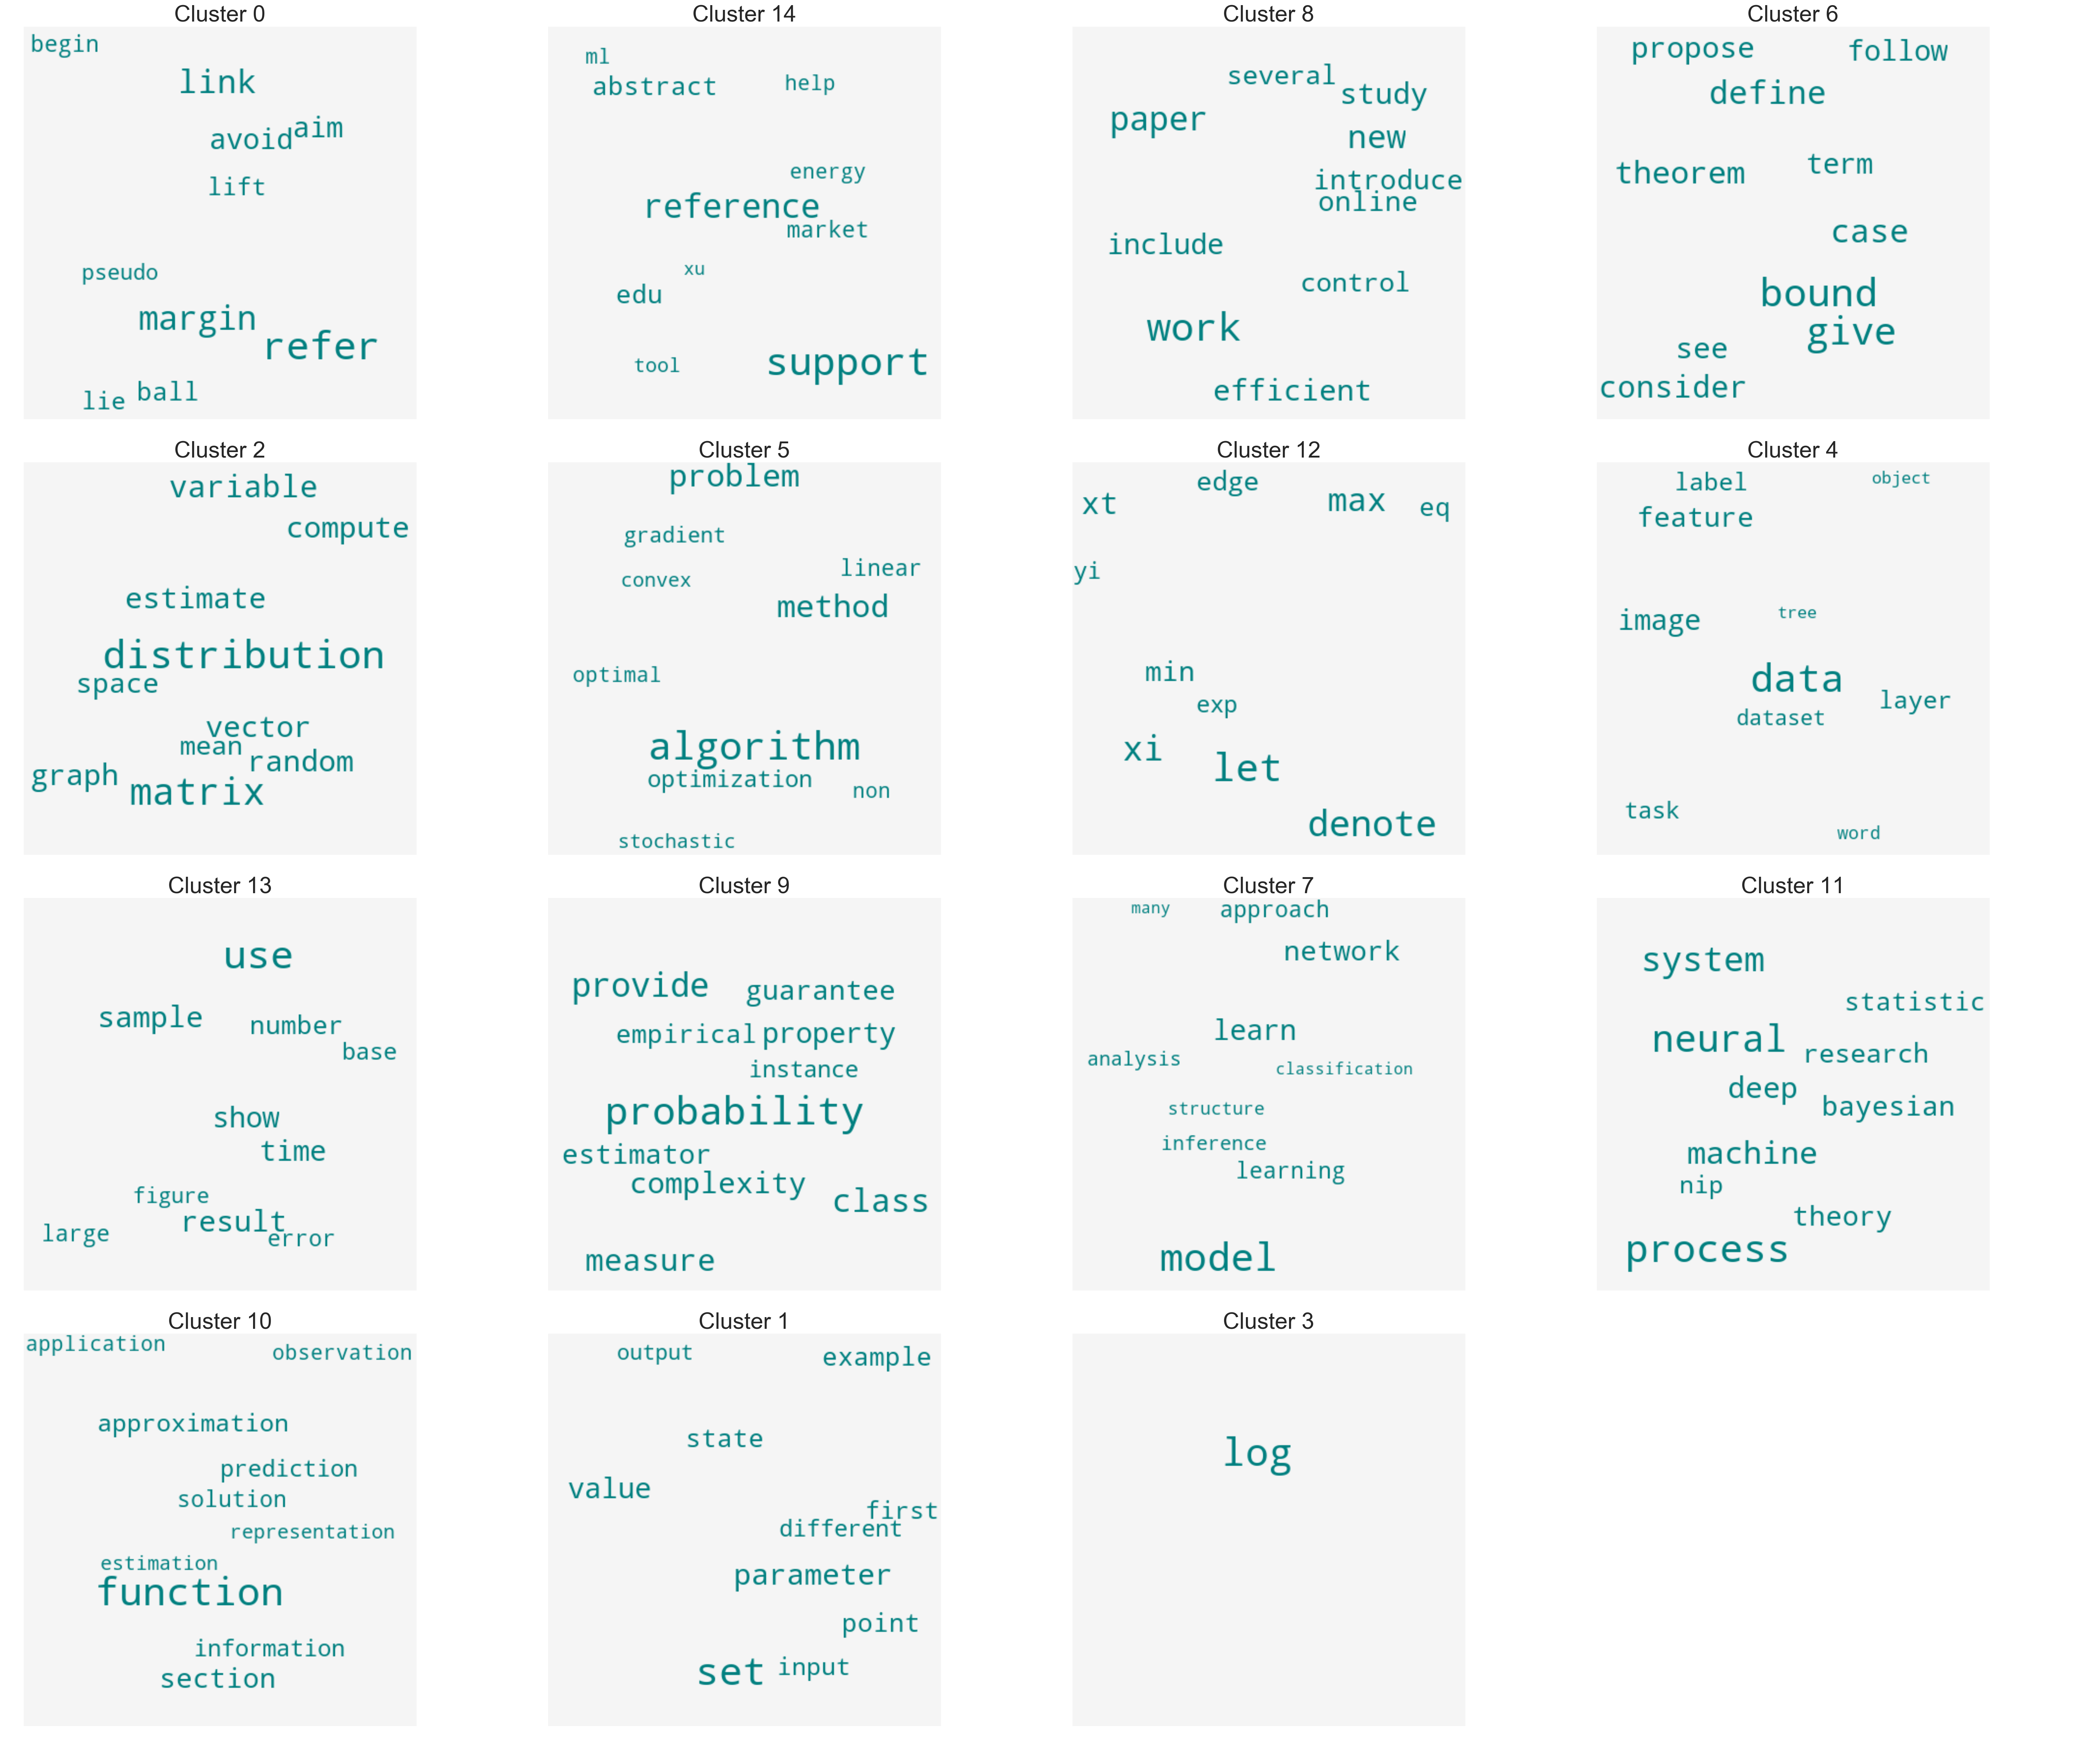

In [38]:
newpd2=cloud_plot(newpd, papers_trigrams,'Clusters.pdf')

In [39]:
#Here I output the first top 10 words of each cluster and save it in the text file "top10words.txt" Clusters are sorted with respect to their size.
def top10(df):
    return df.sort_values('weight',ascending=False).index.values[0:11]
top10words=newpd2.groupby(['Cluster']).apply(top10)[member_count.index.values]
top10words.to_csv('top10words.csv')
top10words

Cluster
0     [refer, margin, link, aim, avoid, ball, lift, lie, begin, pseudo, integer]                                                              
14    [support, reference, abstract, market, energy, help, ml, tool, http, xu, lin]                                                           
8     [work, paper, new, study, efficient, include, introduce, online, control, several, technique]                                           
4     [data, image, feature, label, layer, task, dataset, word, e.g, tree, object]                                                            
2     [distribution, matrix, variable, random, estimate, vector, compute, graph, space, mean, gaussian]                                       
7     [model, learn, network, learning, approach, inference, analysis, structure, classification, many, framework]                            
13    [use, result, sample, show, time, number, base, large, error, figure, step]                                                     

In [40]:
# Since I made trigrams of the original corpus, I need to make a new corpus so I can use it in the following.
flat_paper_id = pd.Series([item for sublist in paper_id for item in sublist])
flat_word = pd.Series([item for sublist in papers_trigrams for item in sublist])
newmsh=pd.DataFrame({'paper_id':flat_paper_id,'word':flat_word})
# Here I join the result of the clustering to the new paper corpus. 
newmsh=newmsh.set_index('word').join(newpd2,how='inner')

Here, I go through each paper and identify what perntage of its content is associated to each word-cluster. I output a csv file "pap_cluster_share.csv" 
that has paper_id, cluster id and percentage of each clsuter.
This is an adhoc approximation for understanding the content of each paper. For example we can say probablity of assigning paper 5633 to cluster 12, 2 and 4 is ..., ... and ...
Note: The best method for doing probabilistic topic modeling is to use the LDA or LDAtoVec algorithms. Here I'm doing probabilistic topic modeling with an adhoc method. 

In [41]:
pap_cluster_share=newmsh.groupby(['paper_id','Cluster']).weight.sum().reset_index().rename(columns={'weight':'weight_sum'}).sort_values(['paper_id','weight_sum','Cluster'],ascending=False)
sharepct=pap_cluster_share.groupby('paper_id').weight_sum.sum()
pap_cluster_share=pap_cluster_share.set_index('paper_id').join(sharepct,rsuffix='_cumsum')
pap_cluster_share['share_pct']=100.0*pap_cluster_share['weight_sum']/pap_cluster_share['weight_sum_cumsum']
pap_cluster_share=pap_cluster_share.drop(['weight_sum','weight_sum_cumsum'],axis=1)
pap_cluster_share.to_csv('pap_cluster_share.csv',index=True)
pap_cluster_share.head(30)

,Cluster,share_pct
paper_id,,
5633,7,38.0433
5633,13,14.0927
5633,4,12.2648
5633,11,7.6528
5633,1,6.6147
5633,5,4.4730
5633,2,4.2000
5633,10,3.8984
5633,6,3.1106


## Another approach: Vector representation of papers. 
#### Trying PCA on each paper.
The above approach has some caveats and if we don't use it inteligently it might make our life more complicated. For example the cluster with the majority of words will always be cluster number 1 for each paper.
To avoid these complications and simply cluster papers into a few topics I use a different approach.
I laverage our FastTex embeddings and use PCA to make vector representations of papers. The I simply run a k-means clustering on the vector representation of papers.
I also use the BIC parameter for model selection and automatically find the optimal number of topics among papers.
In the following I treat each word as a feature and each FastTex columns as a data row.
The result is an embedding vector for each paper.

In [42]:
cols=['paper_id']+list(np.arange(1000).astype(str))
msh2_pca=pd.DataFrame([])
pca = PCA(n_components=1)
for paper_id in newmsh.paper_id.unique():
    result = pca.fit_transform(newmsh[newmsh.paper_id==paper_id].loc[:,cols].T.iloc[1:,:])
    msh2_pca=pd.concat([msh2_pca,pd.DataFrame(result).rename(columns={0:str(paper_id)})],axis=1)
msh2_pca=msh2_pca.T.reset_index().rename(columns={'index':'paper_id'})
msh2_pca.head()

,paper_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,...,900,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,6019,4.5555,-2.9943,2.8794,0.1393,13.9012,19.0792,4.0662,-12.2278,1.1983,0.2014,12.5256,-3.9876,-2.1864,8.3260,-0.4933,0.7312,-5.7458,1.9967,-14.5513,-8.9591,8.5999,-5.3482,-6.5588,-9.8629,1.6218,-7.4382,7.6794,10.0442,-9.3056,-5.1068,-15.2384,-11.7560,-3.4002,-5.9432,-2.9521,12.9937,2.7995,-3.4370,4.6681,-1.1450,-12.3781,8.0325,8.4997,6.8894,3.6081,2.2866,3.2415,-6.7375,1.6680,4.6456,-5.4586,-0.5266,-0.2647,-13.3938,-2.6218,0.2504,-1.5958,0.4431,6.2703,1.4195,-4.3068,-9.7850,-7.6324,-1.7806,-3.8553,-14.0740,-11.5307,7.3348,-7.4656,6.7417,-20.8526,3.2510,-9.2063,5.9538,-4.8882,-7.7791,0.1659,-1.5440,-2.5402,-11.3167,-8.0082,-6.8211,-1.5310,0.1691,-2.5796,0.9571,-8.6112,-0.3074,-14.4862,2.1401,9.2624,10.7250,7.1608,2.4310,5.5790,18.9345,-1.9142,2.9242,6.4365,...,2.9792,15.7051,-3.6566,-9.7231,1.2841,-5.0228,11.9097,-3.0045,-5.9314,5.9195,18.0697,-6.6888,3.4885,-3.6480,-1.7917,-0.7584,2.6318,-2.7581,-8.8912,-3.8458,2.2639,-1.2532,-0.5558,-5.9156,7.6831,0.7728,3.4991,10.7163,-2.7072,-1.6254,4.2982,5.8642,-2.0271,-4.8265,-8.0127,-8.7574,4.0011,-0.9023,10.3699,2.8431,14.4540,5.5700,9.5032,2.1027,0.6330,-2.7993,-4.2716,7.5651,-1.0011,-0.0697,6.1143,-0.2735,-5.3347,-5.2976,-3.7358,-1.4512,11.8581,7.1445,7.5214,4.0955,6.7822,-5.0407,-9.5605,7.8632,-3.9064,-3.1695,-6.3946,11.0084,-6.5929,12.1924,-11.0627,-0.9247,5.8721,9.6234,-9.2342,-0.4199,-3.4039,2.2073,-3.1459,2.7445,0.6355,5.2019,-5.6666,-9.8672,-6.2177,2.0468,-8.6344,10.3645,8.8468,2.0123,-0.2214,-0.7793,11.1239,-8.8982,3.6836,-5.0870,-0.0344,1.5319,-4.9592,-7.3440
1,5802,-5.5956,0.5295,-2.3330,-1.0879,-8.4942,-15.6552,-4.8910,10.0123,-5.3549,-2.1473,-13.0474,-1.9188,-4.3579,-11.0073,-4.1355,-3.3852,6.4213,-5.4993,13.1968,10.0587,-10.0000,6.6769,9.1036,4.2796,1.8581,7.8263,-9.1649,-11.5076,3.9049,4.3563,13.6224,9.1086,4.6823,3.2731,3.7283,-12.5106,2.3585,-1.9383,-4.9662,0.4160,12.1147,-8.5760,-11.3157,-8.5952,-5.7272,0.6921,-3.3605,4.9374,-2.6150,-1.8255,4.5379,1.1934,2.0306,11.7992,3.1757,9.6197,-0.6261,-1.5002,1.9908,-2.3676,-0.0495,8.8149,0.1833,0.4780,3.0735,9.0940,8.6379,-5.1301,0.2392,-1.1385,13.7173,-4.7804,4.8091,-5.2102,1.8636,5.1802,0.0791,1.3180,1.2996,5.2272,8.0828,4.9849,1.6607,-1.1669,3.7461,-2.1475,9.5889,0.9648,15.8994,-2.0966,-4.1545,-10.8902,-10.0078,0.6329,-0.0114,-13.4460,-3.3570,3.1686,-0.1412,...,-0.6928,-16.0089,2.1180,2.4346,-4.0201,7.0079,-7.6551,4.6932,4.8813,-5.4508,-14.9350,10.1765,-0.3759,-6.1741,2.5463,0.8573,3.6217,0.6436,7.7864,6.0950,-1.4929,7.3107,1.1781,0.8798,-7.6928,-5.2804,-3.8597,-12.2684,2.5350,-0.3743,-0.7311,-3.3787,0.6539,-4.9607,9.8542,8.2843,-6.2040,-0.7984,-9.4053,-4.7310,-11.6708,3.2227,-5.3029,-2.9710,-0.9360,4.1450,2.1148,-8.3591,-5.6984,3.3438,-4.9000,0.0429,5.7207,2.9498,0.6321,-2.3403,-8.3461,-5.0987,-6.8191,-0.9757,-0.5695,0.7826,9.2418,-3.4505,-0.6068,4.1950,-2.9772,-8.1285,5.2304,-5.7995,7.3974,5.7972,-1.2701,-2.7530,5.1782,-0.0276,2.6148,-4.4835,-1.0411,-2.8184,4.0528,-1.9405,9.6535,8.0930,6.1323,0.8651,5.3476,-8.4738,-2.3777,2.8971,0.3502,0.7046,-7.2154,6.8069,-6.0807,4.1735,-0.5265,-1.8195,4.0612,16.3912
2,5719,2.3060,0.6402,-0.1313,1.2213,6.5572,9.4688,3.5427,-7.4819,1.1969,3.9793,14.1678,-1.1959,-0.0934,8.0282,1.3260,3.1977,-4.4300,0.3499,-10.6795,-8.2460,8.8207,-2.8036,-4.8231,-6.0979,-4.7463,-5.7052,5.6057,9.5679,-6.0350,1.0473,-

Parse progress: |█████████████████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
kmeans Model Build progress: |████████████████████████████████████████████| 100%
Number of topics K  8
kmeans prediction progress: |█████████████████████████████████████████████| 100%


,paper_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,...,901,902,903,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,Cluster_PCA
0,6019,4.5555,-2.9943,2.8794,0.1393,13.9012,19.0792,4.0662,-12.2278,1.1983,0.2014,12.5256,-3.9876,-2.1864,8.3260,-0.4933,0.7312,-5.7458,1.9967,-14.5513,-8.9591,8.5999,-5.3482,-6.5588,-9.8629,1.6218,-7.4382,7.6794,10.0442,-9.3056,-5.1068,-15.2384,-11.7560,-3.4002,-5.9432,-2.9521,12.9937,2.7995,-3.4370,4.6681,-1.1450,-12.3781,8.0325,8.4997,6.8894,3.6081,2.2866,3.2415,-6.7375,1.6680,4.6456,-5.4586,-0.5266,-0.2647,-13.3938,-2.6218,0.2504,-1.5958,0.4431,6.2703,1.4195,-4.3068,-9.7850,-7.6324,-1.7806,-3.8553,-14.0740,-11.5307,7.3348,-7.4656,6.7417,-20.8526,3.2510,-9.2063,5.9538,-4.8882,-7.7791,0.1659,-1.5440,-2.5402,-11.3167,-8.0082,-6.8211,-1.5310,0.1691,-2.5796,0.9571,-8.6112,-0.3074,-14.4862,2.1401,9.2624,10.7250,7.1608,2.4310,5.5790,18.9345,-1.9142,2.9242,6.4365,...,15.7051,-3.6566,-9.7231,1.2841,-5.0228,11.9097,-3.0045,-5.9314,5.9195,18.0697,-6.6888,3.4885,-3.6480,-1.7917,-0.7584,2.6318,-2.7581,-8.8912,-3.8458,2.2639,-1.2532,-0.5558,-5.9156,7.6831,0.7728,3.4991,10.7163,-2.7072,-1.6254,4.2982,5.8642,-2.0271,-4.8265,-8.0127,-8.7574,4.0011,-0.9023,10.3699,2.8431,14.4540,5.5700,9.5032,2.1027,0.6330,-2.7993,-4.2716,7.5651,-1.0011,-0.0697,6.1143,-0.2735,-5.3347,-5.2976,-3.7358,-1.4512,11.8581,7.1445,7.5214,4.0955,6.7822,-5.0407,-9.5605,7.8632,-3.9064,-3.1695,-6.3946,11.0084,-6.5929,12.1924,-11.0627,-0.9247,5.8721,9.6234,-9.2342,-0.4199,-3.4039,2.2073,-3.1459,2.7445,0.6355,5.2019,-5.6666,-9.8672,-6.2177,2.0468,-8.6344,10.3645,8.8468,2.0123,-0.2214,-0.7793,11.1239,-8.8982,3.6836,-5.0870,-0.0344,1.5319,-4.9592,-7.3440,5
1,5802,-5.5956,0.5295,-2.3330,-1.0879,-8.4942,-15.6552,-4.8910,10.0123,-5.3549,-2.1473,-13.0474,-1.9188,-4.3579,-11.0073,-4.1355,-3.3852,6.4213,-5.4993,13.1968,10.0587,-10.0000,6.6769,9.1036,4.2796,1.8581,7.8263,-9.1649,-11.5076,3.9049,4.3563,13.6224,9.1086,4.6823,3.2731,3.7283,-12.5106,2.3585,-1.9383,-4.9662,0.4160,12.1147,-8.5760,-11.3157,-8.5952,-5.7272,0.6921,-3.3605,4.9374,-2.6150,-1.8255,4.5379,1.1934,2.0306,11.7992,3.1757,9.6197,-0.6261,-1.5002,1.9908,-2.3676,-0.0495,8.8149,0.1833,0.4780,3.0735,9.0940,8.6379,-5.1301,0.2392,-1.1385,13.7173,-4.7804,4.8091,-5.2102,1.8636,5.1802,0.0791,1.3180,1.2996,5.2272,8.0828,4.9849,1.6607,-1.1669,3.7461,-2.1475,9.5889,0.9648,15.8994,-2.0966,-4.1545,-10.8902,-10.0078,0.6329,-0.0114,-13.4460,-3.3570,3.1686,-0.1412,...,-16.0089,2.1180,2.4346,-4.0201,7.0079,-7.6551,4.6932,4.8813,-5.4508,-14.9350,10.1765,-0.3759,-6.1741,2.5463,0.8573,3.6217,0.6436,7.7864,6.0950,-1.4929,7.3107,1.1781,0.8798,-7.6928,-5.2804,-3.8597,-12.2684,2.5350,-0.3743,-0.7311,-3.3787,0.6539,-4.9607,9.8542,8.2843,-6.2040,-0.7984,-9.4053,-4.7310,-11.6708,3.2227,-5.3029,-2.9710,-0.9360,4.1450,2.1148,-8.3591,-5.6984,3.3438,-4.9000,0.0429,5.7207,2.9498,0.6321,-2.3403,-8.3461,-5.0987,-6.8191,-0.9757,-0.5695,0.7826,9.2418,-3.4505,-0.6068,4.1950,-2.9772,-8.1285,5.2304,-5.7995,7.3974,5.7972,-1.2701,-2.7530,5.1782,-0.0276,2.6148,-4.4835,-1.0411,-2.8184,4.0528,-1.9405,9.6535,8.0930,6.1323,0.8651,5.3476,-8.4738,-2.3777,2.8971,0.3502,0.7046,-7.2154,6.8069,-6.0807,4.1735,-0.5265,-1.8195,4.0612,16.3912,1
2,5719,2.3060,0.6402,-0.1313,1.2213,6.5572,9.4688,3.5427,-7.4819,1.1969,3.9793,14.1678,-1.1959,-0.0934,8.0282,1.3260,3.1977,-4.4300,0.3499,-10.6795,-8.2460,8.8207,-2.8036,-4.8231,-6.0979,-4.7463,-5.7052,5.6057,9.5679,-6.0350,1.0473,-14.

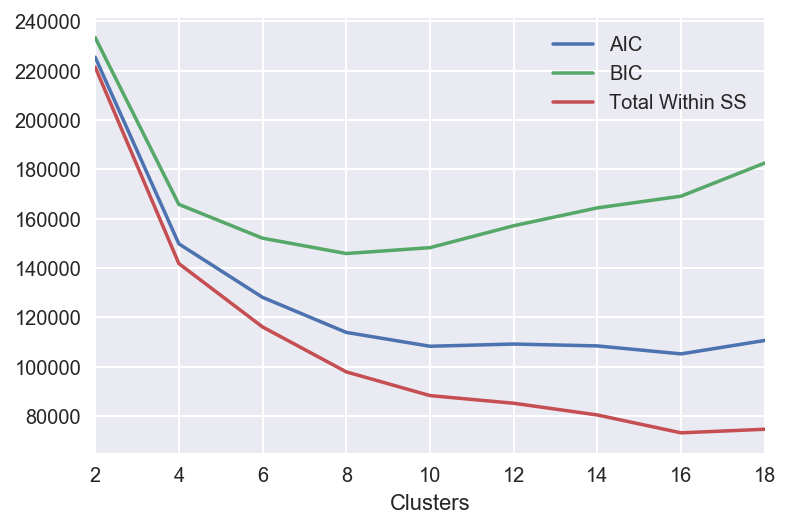

In [43]:
newwd_h=h2o.H2OFrame(msh2_pca,column_names=list(msh2_pca.columns.astype(str)))
minn=2
maxx=20
step=2
results = [H2OKMeansEstimator(k=clusters, init="PlusPlus", seed=2, standardize=True) for clusters in range(minn,maxx, step)]
for estimator in results:
    estimator.train(x=list(pd.DataFrame(msh2_pca.iloc[:,1:]).columns), training_frame = newwd_h[1:])


diagnostics = pd.DataFrame( [diagnostics_from_clusteringmodel(model) for model in results])
diagnostics.set_index('Clusters', inplace=True)
diagnostics.plot(kind='line');


best_cluster=diagnostics[diagnostics['BIC']==diagnostics['BIC'].min()].index[0]
print 'Number of topics K ', best_cluster
# print results
predicted = results[(best_cluster-minn)/step].predict(newwd_h)
newwd_h["Cluster_PCA"] = predicted["predict"].asnumeric()
newdocs2=newwd_h.as_data_frame(True)
newdocs2.head()

#### The results of clustering, cluster ID and its member count

In [44]:
member_count=newdocs2['Cluster_PCA'].value_counts()
[report(member_count.index[i], member_count.iloc[i], 100.0*member_count.iloc[i]/member_count.sum()) for i in range(member_count.shape[0])]

['Cluster: 5 ,Member counts: 74 ,Member share: %18.41',
 'Cluster: 7 ,Member counts: 68 ,Member share: %16.92',
 'Cluster: 6 ,Member counts: 64 ,Member share: %15.92',
 'Cluster: 0 ,Member counts: 62 ,Member share: %15.42',
 'Cluster: 4 ,Member counts: 53 ,Member share: %13.18',
 'Cluster: 1 ,Member counts: 48 ,Member share: %11.94',
 'Cluster: 2 ,Member counts: 23 ,Member share: %5.72',
 'Cluster: 3 ,Member counts: 10 ,Member share: %2.49']

#### Final results
I join the dataframe newdocs2 to our original dataframe pap to get paper titles and abstracts. I save the final clustering result as well as the paper embeddings in the Paper_Embedding_Cluster_PCA.csv file.

In [45]:
newdocs2=newdocs2.set_index('paper_id').join(pap[['Id','Title','Abstract']].set_index('Id'),how='inner')
newdocs2=newdocs2.reset_index().rename(columns={'index':'paper_id'})
newdocs2.to_csv('Paper_Embedding_Cluster_PCA.csv',index=False)


In [46]:
newdocs2[['Cluster_PCA','Title']].sort_values('Cluster_PCA').head(20)

,Cluster_PCA,Title
136,0,Scheduled Sampling for Sequence Prediction with Recurrent Neural Networks
94,0,Learning visual biases from human imagination
286,0,Semi-supervised Convolutional Neural Networks for Text Categorization via Region Embedding
204,0,Attractor Network Dynamics Enable Preplay and Rapid Path Planning in Maze–like Environments
199,0,Where are they looking?
51,0,A Reduced-Dimension fMRI Shared Response Model
197,0,Interactive Control of Diverse Complex Characters with Neural Networks
194,0,Embed to Control: A Locally Linear Latent Dynamics Model for Control from Raw Images
305,0,Are You Talking to a Machine? Dataset and Methods for Multilingual Image Question
101,0,Generative Image Modeling Using Spatial LSTMs


#### Making a TSNE 2 dimentional plot with cluster IDs

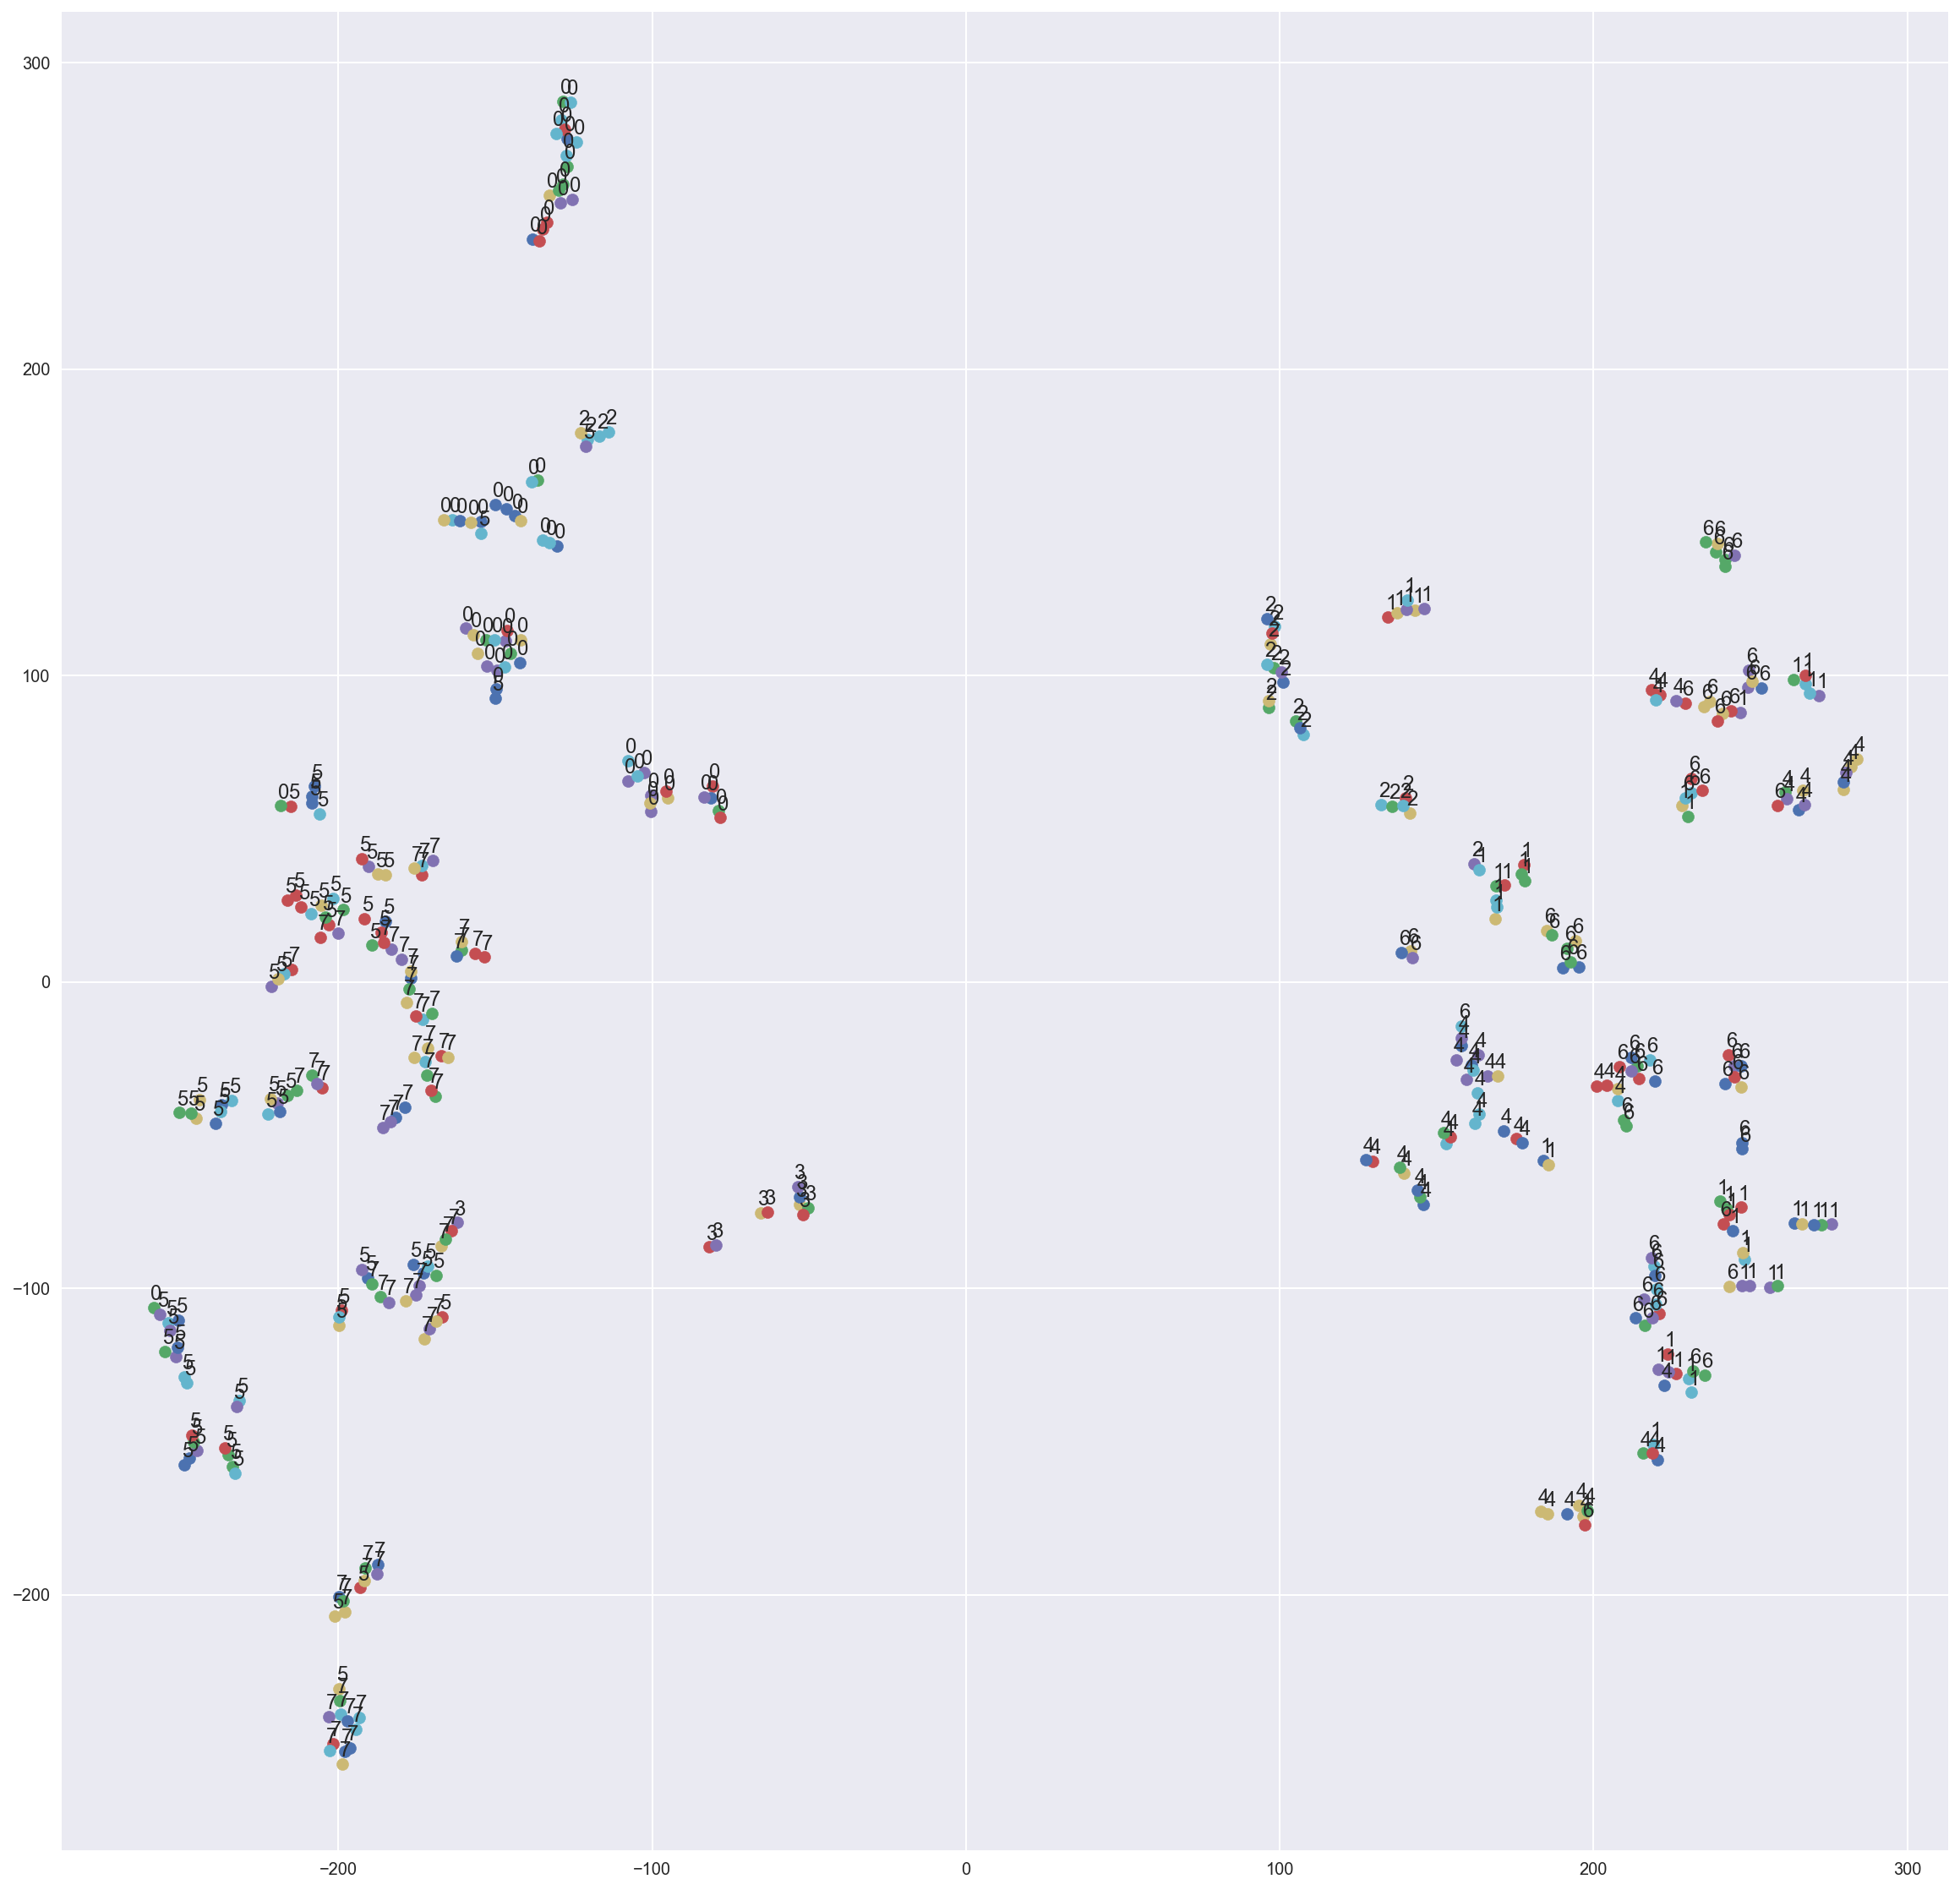

In [47]:
tsne_plot(newdocs2.iloc[:,:-2].set_index('Cluster_PCA').reset_index(),'TSNE_papers_PCA2.pdf' )